# Physical Activity Competition

##### Group 14:

*Sophia Lorenz (13150677) <br>
Nitya Shah (12538639)*

**University of Amsterdam <br>
Big Data Analytics**

## *Table of Contents*

[1. Libraries](#section-one) <br>
[2. Introduction](#section-two) <br>
[3. Data Preprocessing](#section-three) <br>

[4. Feature extraction and selection](#section-four) <br>
- [Statistical time invariant features](#subsection-one) <br>
- [Time domain features (time-variant features)](#subsection-two) <br>
- [Frequency domain features](#subsection-three) <br>
- [Features added from other groups (for Round 2)](#subsection-four) <br>

[5. Function to extract features](#section-five) <br>

[6. Training data](#section-six) <br>

[7. Data cleaning](#section-seven) <br>

[8. Model fitting](#section-eight) <br>
- [Multinomial Logistic Regression](#subsection-one-models) <br>
- [Linear Discriminant Analysis](#subsection-two-models) <br>
- [Quadratic Discriminant Analysis](#subsection-three-models) <br>
- [K Nearest Neighbors](#subsection-four-models) <br>
- [Naive Bayes](#subsection-five-models) <br>

[9. Test data](#section-nine) <br>

[10. Model comparison](#section-ten) <br>

[11. Discussion](#section-eleven) <br>

[12. Submissions](#section-twelve) <br>

[13. References](#section-thirteen) <br>

[14. Task division](#section-fourteen) <br>

<a id="section-one"></a>
## 1 Libraries

In [1]:
library(tidyverse)
library(dplyr)
library(caret)
library(e1071)
library(nnet)
library(MASS)
library(pracma)
library(tidyr)
library(glmnet)
library(pls)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘pracma’


The following object is masked from ‘package:e1071’:

    sigmoid


The following object is masked from ‘package:purrr’:

    cross


Loading required 

<a id="section-two"></a>
## 2 Introduction


### 2.1 Task & Goal

We built a classifier that recognizes different types of physical activity from triaxial signals measured by an accelerometer and gyroscope in smartphones. These measure aspects of movement and orientation. An accelerometer is a sensor that measures acceleration, which is the rate of change of velocity of an object. In simpler terms, it measures how quickly the velocity (speed and direction) of an object is changing. A gyroscope is a sensor that measures angular velocity, which is the rate of change of angular displacement or rotation of an object around a specific axis. A gyroscope measures how quickly an object is rotating or changing its orientation with respect to one or more axes. 


### 2.2 Dataset
Physical activities of n = 30 participants were measured in an experimental environment.The dataset consists of triaxial signals (`X1`, `X2`, `X3`) measured by an accelerometer and gyroscope in smartphones. The data was obtained by n = 30 participants who executed protocoled six basic activities: three stationary postures:
1. standing <br>
2. sitting <br> 
3. lying,<br>

and three dynamic activities:

4. walking <br>
5. walking downstairs, and <br>
6. walking upstairs <br>

The experiment also included postural transitions that occurred between the static postures which were:

7. stand-to-sit <br>
8. sit-to-stand <br>
9. sit-to-lie <br>
10. lie-to-sit <br>
11. stand-to-lie, and <br>
12. lie-to-stand <br>

During the experiment, 3-axial linear acceleration and 3-axial angular velocity were captured at a constant rate of 50Hz using the embedded accelerometer and gyroscope of a smartphone. The experiments were video-recorded to label the data manually. <br>

The obtained movement data was randomly partitioned into a training set containing 70% of the data and a test set containing 30% the test data.

In [2]:
library(tidyverse) 
list.files(path = "../input")

.... = NA

[1] "physical-activity-recognition-bda-2023"

### 2.3 Reading the data

The dataset consists of:
- files containing the raw triaxial signals from accelerometer and gyroscope of each participant for each experiment (trial; 3 trials per person).
- a file containing labels of all the performed activities, the segments of signals for all participants for each experiment.
The data are stored in text (.txt) files. 

In [3]:
# Copy all files to the working directory
system(paste0("cp -r ", list.files("../input", pattern = "recognition", full.names=TRUE), "/* ./"))

# list files in the current working directory
list.files()

# show the content of the labels file 
file.show("activity_labels.txt")

# Train and Test folder are located in the RawData folder
list.files("./RawData")

# The Train folder contains 85 files:
length(list.files("./RawData/Train"))

# A sample of the file names in the Train folder; notice the filename pattern
set.seed(1)
sample(list.files("./RawData/Train"),6)

[1] "activity_labels.txt"    "example_submission.csv" "RawData"               
[4] "README.txt"

[1] "Test"  "Train"

[1] 85

[1] "gyro_exp43_user21.txt" "acc_exp58_user29.txt"  "acc_exp01_user01.txt" 
[4] "acc_exp53_user26.txt"  "gyro_exp01_user01.txt" "acc_exp23_user11.txt"

R Information

1 WALKING           
2 WALKING_UPSTAIRS  
3 WALKING_DOWNSTAIRS
4 SITTING           
5 STANDING          
6 LAYING            
7 STAND_TO_SIT      
8 SIT_TO_STAND      
9 SIT_TO_LIE        
10 LIE_TO_SIT        
11 STAND_TO_LIE      
12 LIE_TO_STAND      


### 2.4 Import activity labels

In [4]:
act_labels = read_delim("activity_labels.txt"," ",col_names=FALSE,trim_ws=TRUE) 
act_labels = act_labels %>% 
    dplyr::select(X1,X2)
act_labels

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 12 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
chr  (1): X2
dbl  (1): X1
lgl (11): X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2
<dbl>,<chr>
1,WALKING
2,WALKING_UPSTAIRS
3,WALKING_DOWNSTAIRS
4,SITTING
5,STANDING
6,LAYING
7,STAND_TO_SIT
8,SIT_TO_STAND
9,SIT_TO_LIE


The signals themselves are stored in text files. In these files there are three columns; each column is the signal measured in one of the 3 channels of the sensor (these channels are associated in X, Y and Z direction). Each signal consists of a sequence of measurements, called _samples_.

In [5]:
labels = read_delim("./RawData/Train/labels_train.txt", " ", col_names = F)
colnames(labels) = c('trial', 'userid', 'activity', 'start', 'end')

labels = labels %>% 
    mutate(activity = act_labels$X2[activity])

labels %>%
    head()

Rows: 849 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (5): X1, X2, X3, X4, X5

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


trial,userid,activity,start,end
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1,STANDING,250,1232
1,1,STAND_TO_SIT,1233,1392
1,1,SITTING,1393,2194
1,1,SIT_TO_STAND,2195,2359
1,1,STANDING,2360,3374
1,1,STAND_TO_LIE,3375,3662


<a id="section-three"></a>
## 3 Data Preprocessing


### 3.1 Merging signals and labels

By merging the the signals and labels we obtain a dataframe that gives an `activity` label for each `trial`, and 'userid' each time `sampleid` has matching row with row in the `signals` dataframe. We can compute this from the labels dataframe where we transform this data by first adding the sequence start:end to each row of `labels` in a list so that we obtain a nested table.

In [6]:
sample_labels_nested = 
    labels %>% 
    rowwise() %>% # do next operation(s) rowwise
    mutate(sampleid = list(start:end)) %>%
    ungroup()

# Check the resulting table:
print(sample_labels_nested, n=6)

# A tibble: 849 × 6
  trial userid activity     start   end sampleid     
  <dbl>  <dbl> <chr>        <dbl> <dbl> <list>       
1     1      1 STANDING       250  1232 <int [983]>  
2     1      1 STAND_TO_SIT  1233  1392 <int [160]>  
3     1      1 SITTING       1393  2194 <int [802]>  
4     1      1 SIT_TO_STAND  2195  2359 <int [165]>  
5     1      1 STANDING      2360  3374 <int [1,015]>
6     1      1 STAND_TO_LIE  3375  3662 <int [288]>  
# ℹ 843 more rows


Then, we unnest the nested table to obtain a table that for each `sampleid` value stores the right `activity` label. What should be noticed is that some activities were repeated at different times during the recording, which results in multiple time (sample) windows in which the participant executes a particular activity. Each row corresponds to a signal segment of an activity. Some of the activities, such as `WALKING`, were executed multiple times in the same experiment in different time segments. We need to be able to identify different segments of`WALKING`. Therefore, before unnesting, we'll add the row numbers as segment ID.

In [7]:
sample_labels = 
    sample_labels_nested %>% 

    # Rows are segments, we need to keep track of different segements
    mutate(segment = row_number()) %>% 

    # Expand the data frame to one sample per row
    unnest(cols = c(sampleid)) %>% 

    # Remove columns we don't need anymore
    dplyr::select(-start, -end) 


# Check the result (first few rows are not interesting; rows 977-990 are)
print(sample_labels[977:990, ])

# A tibble: 14 × 5
   trial userid activity     sampleid segment
   <dbl>  <dbl> <chr>           <int>   <int>
 1     1      1 STANDING         1226       1
 2     1      1 STANDING         1227       1
 3     1      1 STANDING         1228       1
 4     1      1 STANDING         1229       1
 5     1      1 STANDING         1230       1
 6     1      1 STANDING         1231       1
 7     1      1 STANDING         1232       1
 8     1      1 STAND_TO_SIT     1233       2
 9     1      1 STAND_TO_SIT     1234       2
10     1      1 STAND_TO_SIT     1235       2
11     1      1 STAND_TO_SIT     1236       2
12     1      1 STAND_TO_SIT     1237       2
13     1      1 STAND_TO_SIT     1238       2
14     1      1 STAND_TO_SIT     1239       2


<a id="section-four"></a>
## 4 Feature extraction and selection

In order to extract features we define helper functions needed to compute
* Statistical features
* Time domain features, and 
* Frequency domain features

<a id="subsection-one"></a>
### 4.1 Statistical time invariant features

Time-invariant features are characteristics of data that do not change over time. The following are descriptive features that were calculated/derived from signals:
* Mean
* Median
* Quartiles
* Standard deviation
* Maximum
* Minimum
* Mode
* Skewness
* Kurtosis
* Entropy (measure of average surprise)
* Mean signal power (average power of a signal)
* Signal energy

To define features for which there is not a simple function such as mean or standard deviation predefined in basic R, we used custom functions (referenced below). The code below defines those functions, and then employs steps 1 through 3 above to calculate those features.


#### 4.1.1 Mean
The mean tells us the average behaviour of a time series. Time series data may contain noise or fluctuations that vary over time, so the mean can help reduce noise and highlight the underlying, more stable component of the data.


#### 4.1.2 Median
The median is used for similar reasons as the mean. Additionally, the median is more resistant to outliers as compared to the mean. By using the median, we get information about the central 50% of the data distribution without it being too impacted by outliers.


#### 4.1.3 Quartiles
Quartiles are summary statistics which provide valuable information about the distribution and variability of the data. Quartiles provide insights into the spread of data around the median (second quartile or Q2). Q1 represents the lower 25% of the data, while Q3 represents the upper 25%.


#### 4.1.4 Standard deviation
Standard deviation represents the dispersion or variability of data. It measures how data points deviate from the mean of the dataset. 


#### 4.1.5 Maximum and Minimum
The maximum value represents the upper bound/highest point in the dataset which provides insight into the amplitude of the signals. The maximum identifies the most extreme datapoint in the dataset which is relevant for analyzing extreme events or peaks in the data. Similarly, the minimum value represents the lower point/lowest point and gives a broader picture of the range. 


#### 4.1.7 Mode (most common values)
The mode tells us the value or values that occur with the highest frequency in the dataset. The mode may be important in finding the most significant peaks in the dataset.

In [8]:
# mode (most common values) function (adapted from https://www.tutorialspoint.com/r/r_mean_median_mode.htm)

# can delete this:
most_common_value = function(x) {
    counts = table(x, useNA='no')
    most_frequent = which.max(counts)
    return(names(most_frequent))
}

# Alternatively:
find_mode  <- function(x) {
   unique_x <- unique(x)
   unique_x[which.max(tabulate(match(x, unique_x)))]
}

#### 4.1.8 Skewness

Skewness is relevant when extracting features from triaxial movement data because it provides information about the distribution and symmetry of the data, especially when the distribution is not perfectly symmetrical. Skewed data distributions indicates movement patterns or behaviors.  For example positive skewness on the X1 movement axes indicate a bias toward specific types of motion, e.g. `WALKING`.


#### 4.1.9 Kurtosis
Kurtosis is a statistical measure that quantifies the peakedness of a probability distribution. It provides information about the shape of the distribution, particularly in terms of whether it has heavy tails (outliers) or is more peaked around the mean. Kurtosis values can help identify patterns in the movement data. For example, a high kurtosis value suggests that certain axes show frequent, abrupt changes in movement direction or intensity, which may be indicative of specific activities or behaviors.


#### 4.1.10 Entropy
Entropy is a measure of randomness, uncertainty, or average surprise about an observed value. The higher the probability of the outcome, the less surprise. Triaxial movement data can exhibit diverse patterns where entropy can provide insights into the complexity and irregularity of these patterns: high entropy values indicate unpredictable movements, while low entropy values suggest rather regular and structured movement (from Grasman, 2018).

In [9]:
# entropy function (Grasman, 2018)

entropy <- function(x, nbreaks = nclass.Sturges(x)) {
    r = range(x)
    x_binned = findInterval(x, seq(r[1], r[2], len= nbreaks))
    h = tabulate(x_binned, nbins = nbreaks)
    p = h/sum(h)
    -sum(p[p>0] * log(p[p>0]))
}

#### 4.1.11 Signal power
The mean power of a signal is an indication of how large an observation deviates from an absolute zero on the scale of X(s) (Grasman, 2018). In signal processing, mean power is used to characterize the magnitude or intensity of a signal. Higher mean power values indicate more vigorous or intense movements. Sudden changes or abnormalities in mean power values indicate shifts in movement behavior. These shifts may be due to changes in activity patterns.

In [10]:
# Mean signal power function (Grasman, 2018)

mean_power <- function(x) {
    mean(x^2)
}

#### 4.1.12 Signal energy

The energy of a signal, in this case, accelerometer data and gyroscope data, is a measure of the signal's magnitude or amplitude over time. It quantifies the overall "strength" or "intensity" of the signal (Grasman, 2018). Those are expected to differ between the different movements.

In [11]:
# signal energy function

energy <- function(x) {
    sum(x^2)
}

<a id="subsection-two"></a>
### 4.2 Time domain features (time-variant features)

In addition to time-invariant features, we also look at time-specific features, which account and look for features where the sequence of events is important. Those features are interesting because slowly changing signals have high autocorellations, while fast changing signals have low or even negative autocorrelations (Grasman, 2018).
The following time variant features were calculated/derived from signals:

* Autocorrelation
* Cross-correlation

#### 4.2.1 Autocorrelation
Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. Autocorrelation measures the relationship between a variable's current value and its past values (Smith, 2023).

In [12]:
# autocorrelation function

lagged_cor = function(x, y=x, lag=0) {
    
    # compute correlation between x and a time shifted y
    r_lagged = cor(x, dplyr::lag(y, lag), use='pairwise')
    
    return(r_lagged)
}

#### 4.2.2 Crosscorrelation
Besides auto-correlation, we also used the cross correlation function. The cross-correlation function helps determine the correlation/similarity between two signals at different points in time by changing the time lag between them (and re-calculating the correlation) (Williams et al., 2022). It essentially just tells us if signals are related, their strength and the time lag which optimises the correlation. 

**(!!) Note:** Having issues with the cross-correlation function since there are so many values, and not sure which one to index. But the code we tried out is commented out and is below in the code. We tried making our own function and using the `ccf` function on R.


In [13]:
cross_correlation = function(x, y, lag = 0) {
    
    # compute cross-correlation between x and a time-shifted y
    if (lag >= 0) {
        y_lagged = dplyr::lag(y, lag)
        x_truncated = x[1:(length(x) - lag)]
    } else {
        y_lagged = y[(abs(lag) + 1):length(y)]
        x_truncated = x[1:(length(x) - abs(lag))]
    }
    
    r_cross = cor(x_truncated, y_lagged, use = 'pairwise')
    
    return(r_cross)
}


<a id="subsection-three"></a>
### 4.3 Frequency domain features

Frequency domain features in the spectrum of movement signals are statistical and informational characteristics extracted from the signal when it is transformed from the time domain to the frequency domain. These features provide insights into the underlying frequency components and patterns within the movement signal (Grasman, 2018).
The following frequency domain features were calculated/derived from signals:
* Peak frequency
* Mean spectrum frequency
* Standard deviation of spectrum frequency
* Peak-to-peak intervals (PPI)



**Note:** We still have to look into Peak-to-Peak intervals, but it's one of the features we would like to add. 


#### 4.3.1 Peak frequency
The peak frequency refers to the frequency with the highest magnitude or power in the spectrum. This is the frequency at which the spectrum's peak occurs (Grasman, 2018). Peak frequency can provide insights into the characteristic frequencies associated with different movements. Different physical activities and movements often exhibit distinct peak frequencies. For example, `LIE_TO_STAND` may has different peak frequencies in accelerometer data due to differences in gait and motion patterns compared to `WALKING_UPSTAIRS`.

In [14]:
# peak frequency function (from Grasman, 2018)

peak_freq <- function(X) {
    spec = spectrum(X, log='n', plot=F)
    return(spec$freq[which.max(spec$spec)]) # location of the peak
}

#### 4.3.2 Mean and standard deviation of spectrum frequency
Metric regarding the spectrum frequency were added in the following helper function. The mean of spectrum frequency refers to the average frequency at which the signal's energy is distributed. The standard deviation of the spectrum frequency tells how the frequency content of the signal changes over time (Grasman, 2018). 

In [15]:
# spectrum metrics (mean and standard deviation of the spectrum frequency, from Grasman (2018))

spec_stats <- function(X) {
    
    spec = spectrum(X, log='n', plot=FALSE)
    df   = spec$freq[2] - spec$freq[1]
    spec_mean = sum(spec$freq * spec$spec * df)               
    spec_var = sum((spec$freq - spec_mean)^2 * spec$spec * df)  
    
    spec_stats = data.frame(mean = spec_mean, sd = sqrt(spec_var))
    
    return(spec_stats)

}

#### 4.3.3 Peak-to-peak intervals (PPI)

Peak-to-peak intervals (PPI) in accelerometer and gyroscpe data refer to the time intervals between consecutive pairs of peaks in the data. Accelerometer data typically measures acceleration over time, and peaks represent points where the acceleration reaches its maximum value in a positive direction (positive peak) and its minimum value in a negative direction (negative peak). These peaks are often indicative of specific movements or events in the data. Gyroscope data typically measures rotational movements over time. Similar to accelerometer data, peaks in gyroscope data refer to the maximum angular velocities in the gyroscope readings and can thus provide insights into the dynamics of rotational movements captured by the gyroscope.

In [16]:
# peak-to-peak intervals function

peak_intervals <- function(data, threshold = 0) {
  
  # find peaks aka local maxima
  peaks <- which(diff(data) > threshold)
  
  # calculate peak-to-peak intervals
  peak_intervals <- diff(peaks)
  
  return(peak_intervals)
}

<a id="subsection-four"></a>
### 4.4 Features added from other groups (for Round 2)

We will make new models which inlcude these features and then will compare them to our original models. This may help us to see if some features improve the fit, and whether to indeed include more features/these features in our model.

#### 4.4.1  From Group 1

> * "**slope** - Fitting linear regression to all data points within an epoch (X~sampleid) and extracting the slope.
> * **absolute movement** - The absolute movement for one or mutliple axes.
> * **scaled inner product** - The cosine angle between multiple axes. 
> * **RMS** - the root mean square of an epoch"
> * **interquartile range** - the interquartile range between the 25th and 75th percentile within an epoch (there is already an in-built R function"

In [22]:
# (1) slope -----------------------
slope = function(x){
    return(lm(x ~ seq_along(x))$coefficients[2])
}

# (2) absolute movement -----------
absolute_movement = function(vectors){
    return(sum(abs(vectors)))
}

# (3) scaled inner product ---------
scaled_inner_product = function(x, y){
    return((x%*%y / sqrt(sum(x^2) * sum(y^2)))[1])
}

# (4) root mean square (RMS) --------
RMS = function(x){
    return(sqrt(mean(x^2)))
}

#### 4.4.2 From Group 13

We attempted the Peak-to-Peak intervals but were unable to execute it properly. However, group 13 took the distance between peaks which we thought would fit what we had in mind and has worked for them. 

The zero crossing rate (ZCR), Average Resultant Acceleration (ARA) and Signal Magnitude Area (SMA) functions by group 13 also seemto be a good way to capture states of motion well, and the degree of those movements.

> * **distance between peaks**
> * **zero crossing rate (ZCR)**
> * **average resultant acceleration (ARA)**
> * **signal magnitude area (SMA)**

In [23]:
# (1) Distance between peaks --------------------
distance_max <- function(signal) {
  # Sort the 'signal' vector in decreasing order and store the indices
  indices <- order(signal, decreasing = TRUE)
  
  # Select the indices of the two highest values in the 'signal' vector
  index1 <- indices[1]  # Index of the highest value (peak)
  index2 <- indices[2]  # Index of the second highest value (second peak)
  
  # Calculate the absolute distance (number of samples) between the two peaks
  distance <- abs(index2 - index1)
  
  # Return the calculated distance
  return(distance)
}


# (2) Zero Crossing Rate (ZCR) ------------------
calculate_ZCR <- function(signal) {
  zero_crossings <- 0 
  
  # Loop through the signal starting from the second element
  for (i in 2:length(signal)) {
    # Check if the sign of the current element is different from the previous element
    if (sign(signal[i]) != sign(signal[i - 1])) {
      zero_crossings <- zero_crossings + 1  # If it's different, increment the zero crossings counter
    }
  }

  # Calculate the Zero Crossing Rate by dividing the zero crossings by (length - 1)
  zcr <- zero_crossings / (length(signal) - 1)
  
  return(zcr)  # Return the calculated Zero Crossing Rate
}


# (3) Average Resultant Acceleration (ARA) -------------------
ara <- function(x1, x2, x3) {
  # Calculate the square root of the sum of squares for each sample
  sqrt_sum_squares <- sqrt(x1^2 + x2^2 + x3^2)
  
  # Calculate the average of the resultant accelerations across all samples in one epoch
  avg_resultant_acceleration <- mean(sqrt_sum_squares)
  
  # Return the computed average resultant acceleration
  return(avg_resultant_acceleration)
}


# (4) Signal Magnitude Area (SMA) ---------------
sma <- function(x1, x2, x3) {
  # Calculate the mean of the values in each axis (X, Y, Z)
  m1 <- mean(x1)
  m2 <- mean(x2) 
  m3 <- mean(x3) 
  
  # Create a data frame with the mean values and calculate the absolute values
  abs_values <- abs(data.frame(m1, m2, m3))
  
  # Divide the absolute values by 100 and sum them along rows to get SMA values
  sma_values <- rowSums(abs_values / 100)
  
  # Return the calculated SMA values
  return(sma_values)
}

<a id="section-five"></a>
## 5 Function to extract features

The function below considers all statistical features including descriptive time invariant features, time variant features as well as frequency domain features. The following function takes a datafile name and carries out all the steps above so that the features are computed per epoch.

#### Epochs
In the Test data set you will be asked to predict the activities in subsequent time windows, called epochs, of 128 samples (=128 / 50Hz = 2.56 sec). We group the rows in user into epochs, and then compute summary statistics per epoch. The result is a data frame with as many rows as there are epochs, and on each row the summary statistics computed.

In [24]:
extract_features <- function(filename, sample_labels) {
    
    # extract user and experimental run ID's from file name
    username = gsub(".+user(\\d+).+", "\\1", filename) %>% as.numeric()
    expname  = gsub( ".+exp(\\d+).+", "\\1", filename) %>% as.numeric()

    # import the sensor signals from the file
    user01 <- read_delim(filename, " ", col_names = F, progress = TRUE, 
                col_types = "ddd")
    
    # merge signals with labels 
    user_df <- 
        data.frame(userid = username, trial = expname, user01) %>%
        mutate(sampleid = 0:(nrow(user01)-1) ) %>%
        left_join(sample_labels, by = c('userid','trial','sampleid')) 
    
    # split in epochs of 128 samples and compute features per epoch
    user_all_domains <-  user_df %>%
    
          # add an epoch ID variable (on epoch = 2.56 sec)
          mutate(epoch = sampleid %/% 128) %>% 

          # extract statistical features from each epoch
          group_by(epoch) %>%
          summarise(
              
              # keep track of user and experiment information
              user_id = username, 
              exp_id = expname,   
              
              # epoch's activity labels and start sample
              activity = most_common_value(c("-", activity)),
              sampleid = sampleid[1],    
              
              
              ### =================== FEATURES ========================
              ### =====================================================
              
              ## STATISTICAL FEATURES ---------------------------------
              
              # Mean
              mean1 = mean(X1), 
              mean2 = mean(X2), 
              mean3 = mean(X3),

              # Median
              median_1 = quantile(X1, .50),
              median_2 = quantile(X2, .50),
              median_3 = quantile(X3, .50),

              # Quartiles
              q1_25 = quantile(X1, .25),
              q1_75 = quantile(X1, .75),

              q2_25 = quantile(X2, .25),
              q2_75 = quantile(X2, .75),

              q3_25 = quantile(X3, .25),
              q3_75 = quantile(X3, .75),

              # Standard Deviation
              sd1 = sd(X1), 
              sd2 = sd(X2), 
              sd3 = sd(X3), 

              # Maximum
              max1 = max(X1),
              max2 = max(X2),
              max3 = max(X3),

              # Minimum
              min1 = min(X1),
              min2 = min(X2),
              min3 = min(X3),

              # Mode
              mode1 = find_mode(X1),
              mode2 = find_mode(X2),
              mode3 = find_mode(X3),

              # Skewness
              skew1 = e1071::skewness(X1),
              skew2 = e1071::skewness(X2),
              skew3 = e1071::skewness(X3),

              # Kurtosis
              kurtosis1 = e1071::kurtosis(X1),
              kurtosis2 = e1071::kurtosis(X2),
              kurtosis3 = e1071::kurtosis(X3),

              # Entropy
              entropy_1 = entropy(X1),
              entropy_2 = entropy(X2),
              entropy_3 = entropy(X3),

              # Mean signal power
              power1 = mean_power(X1),
              power2 = mean_power(X2),
              power3 = mean_power(X3),
              
              # Signal energy
              energy1 = energy(X1),
              energy2 = energy(X2),
              energy3 = energy(X3),
              
              ### ===================================================== 
              
              ## TIME-DOMAIN FEATURES --------------------------------
              
              # Autoregression correlation
              AR1_1 = lagged_cor(X1, lag=1),
              AR1_2 = lagged_cor(X1, lag=2),

              AR2_1 = lagged_cor(X2, lag=1),
              AR2_2 = lagged_cor(X2, lag=2),

              AR1_3 = lagged_cor(X3, lag=1),
              AR1_3 = lagged_cor(X3, lag=2),

              AR12_1 = lagged_cor(X1, X2, lag=1),
              AR12_2 = lagged_cor(X1, X2, lag=2),

              AR13_1 = lagged_cor(X1, X3, lag=1),
              AR13_2 = lagged_cor(X1, X3, lag=2),

              AR23_1 = lagged_cor(X2, X3, lag=1),
              AR23_2 = lagged_cor(X2, X3, lag=2),

              ## Cross correlations (acf contains the cross-correlations)
              
              # CCF12 = ccf(X1, X2, plot=F)$acf[,,1],
              # CCF13 = ccf(X1, X3, plot=F)$acf[,,1],
              # CCF23 = ccf(X2, X3, plot=F)$acf[,,1]
              
              
              ## ===================================================== 
              
              ## FREQUENCY-DOMAIN FEATURES ---------------------------
              
              # Peak frequencies
              peakFreq1 = peak_freq(X1),
              peakFreq2 = peak_freq(X2),
              peakFreq3 = peak_freq(X3),
              
              # Mean of spectrum
              specMean1 = spec_stats(X1)$mean,
              specMean2 = spec_stats(X2)$mean,
              specMean3 = spec_stats(X3)$mean,
              
              # Standard dev of spectrum 
              specSD1 = spec_stats(X1)$sd,
              specSD2 = spec_stats(X2)$sd,
              specSD3 = spec_stats(X3)$sd,
              
              # Peak-to-Peak Intervals (PPI)
              # PPI1 = peak_intervals(X1),
              # PPI2 = peak_intervals(X2),  
              # PPI3 = peak_intervals(X3),
              
              ### ===================================================== 
              
              ## FEATURES FROM OTHER GROUPS ---------------------------
              
              ## From group 1 --------------------------------
              
              # slope
              slope1 = slope(X1),
              slope2 = slope(X2),
              slope3 = slope(X3),
                
              # absolute movement
              abs_mov1 = absolute_movement(X1),
              abs_mov2 = absolute_movement(X2),
              abs_mov3 = absolute_movement(X3),
              
              abs_mov1_2 = absolute_movement(c(X1, X2)),
              abs_mov1_3 = absolute_movement(c(X1, X3)),
              abs_mov2_3 = absolute_movement(c(X2, X3)),
              
              # scaled inner product
              scaled_inner_product1_2 = scaled_inner_product(X1, X2),
              scaled_inner_product1_3 = scaled_inner_product(X1, X3),
              scaled_inner_product2_3 = scaled_inner_product(X2, X3),
              
              # root mean square (RMS) 
              rms1 = RMS(X1),
              rms2 = RMS(X2),
              rms3 = RMS(X3),
              
              # interquartile range (IQR)
              iqr1 = IQR(X1),
              iqr2 = IQR(X2),
              iqr3 = IQR(X3),
            
              ## From Group 13 ----------------------------------
              
              # distance between peaks
              dist_max1 = distance_max(X1),
              dist_max2 = distance_max(X2),
              dist_max3 = distance_max(X3),
              
              # zero crossing rate
              zcr1 = calculate_ZCR(X1),
              zcr2 = calculate_ZCR(X2),
              zcr3 = calculate_ZCR(X3),
              
              # Average Resultant Acceleration (ARA)
              ara = ara(X1,X2,X3),
              
              # Signal Magnitude Area (SMA)
              sma = sma(X1,X2,X3),
        
              # keeping track of samples
              n_samples = n()
          ) 
    
    user_all_domains 
}

<a id="section-six"></a>
## 6 Training data

### 6.1 Extract features on all elements of training data
We apply the extract_features() function on all elements in accelerometer training files and gyroscope training files. The following code merges the data of files into one dataframe using `map_dfr()` for both accelerometer training files and gyroscope trainng files. 

In [25]:
# dir() to obtain a list of all files
# map_dfr runs `extractTimeDomainFeatures` on all elements in filenames and binds results row wise


### ACCELEROMETER TRAINING DATA ---------------------------------------

# obtain a list of all files
acc_filenames <- dir("./RawData/Train/", "^acc", full.names = TRUE)

# run extract_features() on all elements in obtained files and bind results of the accelerometer data files row wise
acc_train_data = map_dfr(acc_filenames, extract_features, sample_labels) 

# rename columns by assing acc_ at the beginning of each name
# acc_train_data = acc_train_data %>% rename_with(~paste0("acc_", .x), 6:length(names(acc_train_data)))


### GYROSCOPE TRAINING DATA -------------------------------------------

# obtain a list of all files
gyro_filenames <- dir("./RawData/Train/", "^gyro", full.names = TRUE)

# run extract_features() on all elements in obtained files and bind results of the gyroscope data files row wise
gyro_train_data = map_dfr(gyro_filenames, extract_features, sample_labels) 

# rename columns by assing gyr_ at the beginning of each name
# gyro_train_data = gyro_train_data %>% rename_with(~paste0("gyr_", .x), 6:length(names(gyro_train_data)))

In [26]:
# checking that the training data was imported

acc_train_data %>% head(3)
gyro_train_data %>% head(3)

epoch,user_id,exp_id,activity,sampleid,mean1,mean2,mean3,median_1,median_2,⋯,iqr3,dist_max1,dist_max2,dist_max3,zcr1,zcr2,zcr3,ara,sma,n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,1,1,-,0,0.908941,-0.1649089,0.25218100,0.862500,-0.1437500,⋯,0.637500033,1,56,1,0,0.01574803,0.04724409,1.025068,0.01326031,128
1,1,1,STANDING,128,1.015723,-0.1324110,0.05088976,1.020833,-0.1277778,⋯,0.084027781,30,3,31,0,0.01574803,0.11023622,1.032061,0.01199023,128
2,1,1,STANDING,256,1.019217,-0.1241102,0.09873047,1.019445,-0.1250000,⋯,0.005555555,11,29,21,0,0.00000000,0.00000000,1.031503,0.01242057,128


epoch,user_id,exp_id,activity,sampleid,mean1,mean2,mean3,median_1,median_2,⋯,iqr3,dist_max1,dist_max2,dist_max3,zcr1,zcr2,zcr3,ara,sma,n_samples
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,1,1,-,0,-0.135108596,-0.209283383,-0.023363209,-0.078343470,0.0009162978,⋯,0.363235744,1,1,35,0.2047244,0.2440945,0.2362205,0.91313559,0.0036775519,128
1,1,1,STANDING,128,0.023394230,0.051732651,0.004068458,0.011148291,0.0270307874,⋯,0.096669425,83,14,4,0.3228346,0.2834646,0.3228346,0.41125411,0.0007919534,128
2,1,1,STANDING,256,0.008618927,-0.002727418,0.002398123,0.007330383,-0.0022907447,⋯,0.007788532,2,1,5,0.1732283,0.3858268,0.3228346,0.01470045,0.0001374447,128


### 6.2 Merging training data

In order to process all data, the resulting dataframes of features from all files were combined in one dataframe along with five other variables. This dataframe contains accelerometer training data files (the ones ending with `acc`) as well as gyroscope training data (filenames ending with `gyro`).

In [27]:
train_data <- acc_train_data %>%
  left_join(gyro_train_data, 
            by = c("epoch", "user_id", "exp_id", "sampleid", "activity", "n_samples"), 
            suffix = c("_acc", "_gyro")) # to distinguish between same columns of two diff datasets

dim(train_data) # 6252 x 176

# bringing n_samples column ahead
train_data <- train_data %>%
  dplyr::select(epoch, user_id, exp_id, activity, sampleid, n_samples, everything())

train_data %>% head(3)

[1] 6252  176

epoch,user_id,exp_id,activity,sampleid,n_samples,mean1_acc,mean2_acc,mean3_acc,median_1_acc,⋯,iqr2_gyro,iqr3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,ara_gyro,sma_gyro
<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,1,-,0,128,0.908941,-0.1649089,0.25218100,0.862500,⋯,0.764726918,0.363235744,1,1,35,0.2047244,0.2440945,0.2362205,0.91313559,0.0036775519
1,1,1,STANDING,128,128,1.015723,-0.1324110,0.05088976,1.020833,⋯,0.358425189,0.096669425,83,14,4,0.3228346,0.2834646,0.3228346,0.41125411,0.0007919534
2,1,1,STANDING,256,128,1.019217,-0.1241102,0.09873047,1.019445,⋯,0.008017606,0.007788532,2,1,5,0.1732283,0.3858268,0.3228346,0.01470045,0.0001374447


<a id="section-seven"></a>
## 7 Data cleaning

TODO:
- For the competition submision you should only provide predictions for the epochs defined in the sample submission file



Should you remove the epochs that do not consist of 128 samples in the df?



### 7.1 Remove unlabelled epochs from the training data

Epochs maked with `-` are unlabelled epochs. We removed unlabelled epochs from the training data because they do not add anything to our prediction.

In [28]:
# filter out unlabelled epochs ("-")

train_data_filtered <- train_data %>%
  filter(activity != "-")

train_data_filtered %>%
    head(6)
dim(train_data_filtered) # 4900 x 176

colnames(train_data_filtered) # ALL features

epoch,user_id,exp_id,activity,sampleid,n_samples,mean1_acc,mean2_acc,mean3_acc,median_1_acc,⋯,iqr2_gyro,iqr3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,ara_gyro,sma_gyro
<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,STANDING,128,128,1.015723,-0.1324110,0.05088976,1.020833,⋯,0.358425189,0.096669425,83,14,4,0.32283465,0.2834646,0.3228346,0.41125411,7.919534e-04
2,1,1,STANDING,256,128,1.019217,-0.1241102,0.09873047,1.019445,⋯,0.008017606,0.007788532,2,1,5,0.17322835,0.3858268,0.3228346,0.01470045,1.374447e-04
3,1,1,STANDING,384,128,1.020074,-0.1254232,0.09264323,1.020833,⋯,0.009621128,0.012904528,1,24,20,0.07086614,0.2755906,0.2440945,0.02255514,1.871729e-04
4,1,1,STANDING,512,128,1.020172,-0.1297960,0.08509115,1.019445,⋯,0.010461067,0.012446379,2,7,2,0.22047244,0.2519685,0.2440945,0.01562253,1.531935e-05
5,1,1,STANDING,640,128,1.020757,-0.1285590,0.08496094,1.020833,⋯,0.012904528,0.016951510,3,4,17,0.14960630,0.2598425,0.1653543,0.02028489,1.458202e-04
6,1,1,STANDING,768,128,1.020486,-0.1384549,0.07394749,1.020139,⋯,0.008323039,0.010231993,1,1,1,0.18897638,0.3228346,0.1968504,0.01481578,7.294590e-05


[1] 4900  176

[1] "epoch"                        "user_id"                     
  [3] "exp_id"                       "activity"                    
  [5] "sampleid"                     "n_samples"                   
  [7] "mean1_acc"                    "mean2_acc"                   
  [9] "mean3_acc"                    "median_1_acc"                
 [11] "median_2_acc"                 "median_3_acc"                
 [13] "q1_25_acc"                    "q1_75_acc"                   
 [15] "q2_25_acc"                    "q2_75_acc"                   
 [17] "q3_25_acc"                    "q3_75_acc"                   
 [19] "sd1_acc"                      "sd2_acc"                     
 [21] "sd3_acc"                      "max1_acc"                    
 [23] "max2_acc"                     "max3_acc"                    
 [25] "min1_acc"                     "min2_acc"                    
 [27] "min3_acc"                     "mode1_acc"                   
 [29] "mode2_acc"                    "mode3_acc"                   
 [31] "skew1_acc"                    "skew2_acc"                   
 [33] "skew3_acc"                    "kurtosis1_acc"               
 [35] "kurtosis2_acc"                "kurtosis3_acc"               
 [37] "entropy_1_acc"                "entropy_2_acc"               
 [39] "entropy_3_acc"                "power1_acc"                  
 [41] "power2_acc"                   "power3_acc"                  
 [43] "energy1_acc"                  "energy2_acc"                 
 [45] "energy3_acc"                  "AR1_1_acc"                   
 [47] "AR1_2_acc"                    "AR2_1_acc"                   
 [49] "AR2_2_acc"                    "AR1_3_acc"                   
 [51] "AR12_1_acc"                   "AR12_2_acc"                  
 [53] "AR13_1_acc"                   "AR13_2_acc"                  
 [55] "AR23_1_acc"                   "AR23_2_acc"                  
 [57] "peakFreq1_acc"                "peakFreq2_acc"               
 [59] "peakFreq3_acc"                "specMean1_acc"               
 [61] "specMean2_acc"                "specMean3_acc"               
 [63] "specSD1_acc"                  "specSD2_acc"                 
 [65] "specSD3_acc"                  "slope1_acc"                  
 [67] "slope2_acc"                   "slope3_acc"                  
 [69] "abs_mov1_acc"                 "abs_mov2_acc"                
 [71] "abs_mov3_acc"                 "abs_mov1_2_acc"              
 [73] "abs_mov1_3_acc"               "abs_mov2_3_acc"              
 [75] "scaled_inner_product1_2_acc"  "scaled_inner_product1_3_acc" 
 [77] "scaled_inner_product2_3_acc"  "rms1_acc"                    
 [79] "rms2_acc"                     "rms3_acc"                    
 [81] "iqr1_acc"                     "iqr2_acc"                    
 [83] "iqr3_acc"                     "dist_max1_acc"               
 [85] "dist_max2_acc"                "dist_max3_acc"               
 [87] "zcr1_acc"                     "zcr2_acc"                    
 [89] "zcr3_acc"                     "ara_acc"                     
 [91] "sma_acc"                      "mean1_gyro"                  
 [93] "mean2_gyro"                   "mean3_gyro"                  
 [95] "median_1_gyro"                "median_2_gyro"               
 [97] "median_3_gyro"                "q1_25_gyro"                  
 [99] "q1_75_gyro"                   "q2_25_gyro"                  
[101] "q2_75_gyro"                   "q3_25_gyro"                  
[103] "q3_75_gyro"                   "sd1_gyro"                    
[105] "sd2_gyro"                     "sd3_gyro"                    
[107] "max1_gyro"                    "max2_gyro"                   
[109] "max3_gyro"                    "min1_gyro"                   
[111] "min2_gyro"                    "min3_gyro"                   
[113] "mode1_gyro"                   "mode2_gyro"                  
[115] "mode3_gyro"                   "skew1_gyro"                  
[117] "skew2_gyro"                   "skew3_gyro"         

### 7.2 Removing NAs

In [29]:
train_data_filtered <- na.omit(train_data_filtered)
dim(train_data_filtered) # nothing was filtered

[1] 4900  176

In [ ]:
# checking for NAs in each column

na_in_columns <- train_data_filtered %>%
  summarise_all(~ sum(is.na(.))) %>%
  pivot_longer(everything(), names_to = "column_name", values_to = "NA_count") %>%
  filter(NA_count > 0)

na_in_columns # there are no columns where the NA count is above 0


## To see the NA counts for all the columns: -------------------------

# train_data_filtered %>% summarise_all(~ sum(is.na(.))) %>% pivot_longer(everything(), names_to = "Column", values_to = "NA_Count")



There are no NAs in any of the columns, as can be seen using the output of the code above. Hence, there is no need to remove any of them.

### 7.3 Remove redundant variables 

Next, we use the `caret` package to remove redundant variables. We remove variables which (have/are):

* Near-zero variance
* Highly correlated variables
* Multi-collinearity

Redunant variables can be removed from the training dataset because they do not contribute meaningful information to the analysis and do not help discriminate between observations. By removing such variables, we simplify our model, which can lead to more interpretable results and understandable models. 

Moreover, having too many features or variables, especially those with low or no variance, can lead to overfitting. By removing uninformative variables, we reduce the risk of overfitting and improve the model's generalization to new data. 

Finally, redunant variables increase the computational cost of modeling and analysis without providing any real benefit. Removing them can speed up the processing time and reduce memory usage.

#### 7.3.1 Near-zero variance

Variables with near-zero variation are variables with mostly one and the same value. Variables with no or very little variation can be removed from the training dataset because they are essentially constant and do not help discriminate between observations.

*Only 1 variable ("zcr1_acc") was removed due to this reason.*

In [30]:
# checking all columns except the first 6
# first 6 cols are - sampleid, userid, epoch, activity, expid, n_samples
zeroVars <- caret::nearZeroVar(train_data_filtered %>%
    dplyr::select(-c(1:6))) 

length(zeroVars) # = 1

zeroVar_index = (7:ncol(train_data_filtered))[zeroVars]
zeroVar_index # col 87 to be removed

# Remove the near zero variance variable
train_data_filtered <- train_data_filtered %>%
  dplyr::select(-all_of(zeroVar_index))

train_data_filtered %>% head(2)
dim(train_data_filtered)


# Check which columns had near zero variance and were removed
removed_columns <- train_data %>%
  dplyr::select(-all_of(colnames(train_data_filtered))) %>%
  names()

print(removed_columns)

[1] 1

[1] 87

epoch,user_id,exp_id,activity,sampleid,n_samples,mean1_acc,mean2_acc,mean3_acc,median_1_acc,⋯,iqr2_gyro,iqr3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,ara_gyro,sma_gyro
<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,STANDING,128,128,1.015723,-0.1324110,0.05088976,1.020833,⋯,0.358425189,0.096669425,83,14,4,0.3228346,0.2834646,0.3228346,0.41125411,0.0007919534
2,1,1,STANDING,256,128,1.019217,-0.1241102,0.09873047,1.019445,⋯,0.008017606,0.007788532,2,1,5,0.1732283,0.3858268,0.3228346,0.01470045,0.0001374447


[1] 4900  175

[1] "zcr1_acc"


The variable `zcr1_acc` was removed due to near-zero variance.

#### 7.3.2 Highly correlated variables

High correlation between features indicate they provide same or very similar information. This leads to instability of coefficient estimates (collinearity or inestimability in the worst cases). In order to correct for these highly correlated variables approach we removed one of the two correlated features for the reasons described above.

In [37]:
# calculate the correlation matrix for columns 7 and onwards
# first 6 cols are - sampleid, userid, epoch, activity, expid, n_samples
cor_train_data <- train_data_filtered %>%
  select(7:ncol(train_data_filtered)) %>%
  cor()

# identify highly correlated pairs
high_cor_pairs <- findCorrelation(cor_train_data)

# get the column indices of the highly correlated columns
high_cor_cols <- (7:ncol(train_data_filtered))[high_cor_pairs]

# remove the highly correlated columns
train_data_filtered <- train_data_filtered %>%
  select(-all_of(high_cor_cols))

# check the dimensions after removing columns
dim(train_data_filtered) # 4900 x 112

ERROR: Error in parse(text = x, srcfile = src): <text>:3:7: unexpected '['
2: cor_train_data <- train_data_filtered %>%
3:   cor([
         ^


In [31]:
# correlation matrix for columns 7 and onwards 
# first 6 cols are - sampleid, userid, epoch, activity, expid, n_samples
cor_train_data <- cor(train_data_filtered[, 7:ncol(train_data_filtered)])

high_cor_pairs <- caret::findCorrelation(cor_train_data)

# get the column indices of the highly correlated columns
high_cor_cols <- (7:ncol(train_data_filtered))[high_cor_pairs]

length(high_cor_cols) # = 63

# remove the highly correlated columns
train_data_filtered <- train_data_filtered %>%
  dplyr::select(-all_of(high_cor_cols))

train_data_filtered %>% head(3)
dim(train_data_filtered) # 4900 x 112

[1] 63

epoch,user_id,exp_id,activity,sampleid,n_samples,q1_25_acc,max2_acc,max3_acc,skew1_acc,⋯,scaled_inner_product2_3_gyro,iqr2_gyro,iqr3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,sma_gyro
<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,STANDING,128,128,0.9861112,0.005555556,0.3472222,-0.07560850,⋯,0.1407538,0.358425189,0.096669425,83,14,4,0.32283465,0.2834646,0.3228346,0.0007919534
2,1,1,STANDING,256,128,1.0180556,-0.115277783,0.1097222,0.01030481,⋯,-0.4932199,0.008017606,0.007788532,2,1,5,0.17322835,0.3858268,0.3228346,0.0001374447
3,1,1,STANDING,384,128,1.0180556,-0.108333336,0.1097222,-0.37654877,⋯,-0.4992935,0.009621128,0.012904528,1,24,20,0.07086614,0.2755906,0.2440945,0.0001871729


[1] 4900  112

A total of 63 variables were removed due to high correlation among those variables. One variable of each pair of correlated variables was removed.


#### 7.3.3 Multicollinearity

Multicollinearity refers to the situation where two or more variables are highly correlated, meaning linearly related. In fact, those variables can be exactly predicted from other features. Multicollinearity should be managed for reasons descriebed above.

In [38]:
# checking all columns except the first 6
# first 6 cols are - sampleid, userid, epoch, activity, expid, n_samples
linear_combos <- caret::findLinearCombos(train_data_filtered[ ,-c(1:6)])

# checking which columns to remove
linear_combo_index <- (7:ncol(train_data_filtered))[linear_combos$remove]

print(linear_combo_index) 
length(linear_combo_index)

# Removing cols 104 and 105
train_data_filtered <- train_data_filtered %>%
  dplyr::select(-all_of(linear_combo_index))

# checking
train_data_filtered %>% head(3)
dim(train_data_filtered)


[1] 104 105


[1] 2

epoch,user_id,exp_id,activity,sampleid,n_samples,q1_25_acc,max2_acc,max3_acc,skew1_acc,⋯,scaled_inner_product1_2_gyro,scaled_inner_product1_3_gyro,scaled_inner_product2_3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,sma_gyro
<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,STANDING,128,128,0.9861112,0.005555556,0.3472222,-0.07560850,⋯,0.2905026,0.23092866,0.1407538,83,14,4,0.32283465,0.2834646,0.3228346,0.0007919534
2,1,1,STANDING,256,128,1.0180556,-0.115277783,0.1097222,0.01030481,⋯,-0.2073429,0.06151575,-0.4932199,2,1,5,0.17322835,0.3858268,0.3228346,0.0001374447
3,1,1,STANDING,384,128,1.0180556,-0.108333336,0.1097222,-0.37654877,⋯,-0.2716836,0.13905539,-0.4992935,1,24,20,0.07086614,0.2755906,0.2440945,0.0001871729


[1] 4900  110

Two linear combinations were found. One variable of each combination were removed.

### 7.4 Preparing the data frame for model fitting

We removed some columns (IDs, etc.) except `activity` of the df before we fit models on the training data.

In [39]:
train_data_filtered = train_data_filtered %>% # re-ordering cols
    dplyr::select(epoch, user_id, exp_id, sampleid, n_samples, activity, everything())

# removing columns 1:5 (epoch, userid, expid, sampleid, n_samples)
train_df_final = train_data_filtered %>%
    dplyr::select(-c(1:5))

train_df_final %>%
    head(3)
dim(train_df_final) # 4900 x 105 (104 predictors)

activity,q1_25_acc,max2_acc,max3_acc,skew1_acc,skew2_acc,skew3_acc,kurtosis1_acc,kurtosis2_acc,kurtosis3_acc,⋯,scaled_inner_product1_2_gyro,scaled_inner_product1_3_gyro,scaled_inner_product2_3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,sma_gyro
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
STANDING,0.9861112,0.005555556,0.3472222,-0.07560850,-0.03534337,-1.63249742,1.5460273,1.1506106,4.6589622,⋯,0.2905026,0.23092866,0.1407538,83,14,4,0.32283465,0.2834646,0.3228346,0.0007919534
STANDING,1.0180556,-0.115277783,0.1097222,0.01030481,-0.16029915,-0.95896747,0.6269858,-0.3818571,2.3792777,⋯,-0.2073429,0.06151575,-0.4932199,2,1,5,0.17322835,0.3858268,0.3228346,0.0001374447
STANDING,1.0180556,-0.108333336,0.1097222,-0.37654877,0.42325422,0.03989466,0.7756232,-0.7845402,-0.4242149,⋯,-0.2716836,0.13905539,-0.4992935,1,24,20,0.07086614,0.2755906,0.2440945,0.0001871729


[1] 4900  105

<a id="section-eight"></a>
## 8 Model fitting

Based on the preprocessed training data we fitted classification models: 

1. **Multinomial logistic regression**: Logistic regression does not work here because logistic regression is used for binary classification problems (two classes, e.g. walking vs. not walking). Thus, we should use the extension of binary logistic regression, multinomial logistic regression, because we are faced with a multiclass classification problem (more than two classes).
2. **Linear Discriminant Analysis**
3. **Quadratic Discriminant Analysis**
4. **k-NN**
5. **Naive Bayes**

All of these models were performed twice; once with our original features, once with our original features plus the additional ones we added from other groups.


### Cross-validation

**Resampling methods**

Resampling methods allow to examine the extent to which resulting model fits differ as compared to when we were to only fit the model once on the full set of original training sample. It involves repreatedly drawing samples from the training set and refit the model of interest on each sample to obtain additional information about the fitted model (James et al., 2021).

**Cross-validation**

Cross-validation is one resampling method which estimates the test error that goes ahand with statistical learning methods in order to evaluate its performance. In cross-validation the test error rate is estimated by holding out a subset of training observations from the fitting process and applying the statistical learning method on those held out observations (James et al., 2021). 

**k-Fold Cross-Validation**

Here, we decided on k-Fold Cross-Validation resampling method. This approach involves randomly dividing the set of observations into equally sized k folds. The first fold is treated as validation set whereas the remaining k-1 folds are the training sets on which the method is fit.The procedure is repeated k times such that each time a different group of observations (fold) gets treated as validation set (James et al., 2021).  In order to choose the number of folds one needs to take the bias-variance tradeoff into consideration (James et al., 2021).

> "k=10: The value for k is fixed to 10, a value that has been found through experimentation to generally result in a model skill estimate with low bias and modest variance." (Brownlee, 2018)

### Models with lesser / more features

We compare models with the features we used originally and then re-run the same models with additional features from other groups. 

In [40]:
# Final features
colnames(train_df_final)

[1] "activity"                     "q1_25_acc"                   
  [3] "max2_acc"                     "max3_acc"                    
  [5] "skew1_acc"                    "skew2_acc"                   
  [7] "skew3_acc"                    "kurtosis1_acc"               
  [9] "kurtosis2_acc"                "kurtosis3_acc"               
 [11] "entropy_1_acc"                "entropy_2_acc"               
 [13] "entropy_3_acc"                "AR1_2_acc"                   
 [15] "AR2_1_acc"                    "AR2_2_acc"                   
 [17] "AR1_3_acc"                    "AR12_2_acc"                  
 [19] "AR13_1_acc"                   "AR23_2_acc"                  
 [21] "peakFreq1_acc"                "peakFreq2_acc"               
 [23] "peakFreq3_acc"                "specMean1_acc"               
 [25] "specMean2_acc"                "specMean3_acc"               
 [27] "slope1_acc"                   "slope2_acc"                  
 [29] "slope3_acc"                   "abs_mov1_2_acc"              
 [31] "abs_mov1_3_acc"               "scaled_inner_product1_2_acc" 
 [33] "scaled_inner_product1_3_acc"  "scaled_inner_product2_3_acc" 
 [35] "rms2_acc"                     "rms3_acc"                    
 [37] "iqr1_acc"                     "iqr2_acc"                    
 [39] "iqr3_acc"                     "dist_max1_acc"               
 [41] "dist_max2_acc"                "dist_max3_acc"               
 [43] "zcr2_acc"                     "zcr3_acc"                    
 [45] "ara_acc"                      "sma_acc"                     
 [47] "mean2_gyro"                   "mean3_gyro"                  
 [49] "median_1_gyro"                "median_2_gyro"               
 [51] "median_3_gyro"                "q1_25_gyro"                  
 [53] "q1_75_gyro"                   "q2_25_gyro"                  
 [55] "q2_75_gyro"                   "q3_25_gyro"                  
 [57] "q3_75_gyro"                   "max1_gyro"                   
 [59] "max2_gyro"                    "max3_gyro"                   
 [61] "min1_gyro"                    "min2_gyro"                   
 [63] "min3_gyro"                    "mode1_gyro"                  
 [65] "mode2_gyro"                   "mode3_gyro"                  
 [67] "skew1_gyro"                   "skew2_gyro"                  
 [69] "skew3_gyro"                   "kurtosis1_gyro"              
 [71] "kurtosis2_gyro"               "kurtosis3_gyro"              
 [73] "entropy_1_gyro"               "entropy_2_gyro"              
 [75] "entropy_3_gyro"               "energy1_gyro"                
 [77] "energy2_gyro"                 "energy3_gyro"                
 [79] "AR1_1_gyro"                   "AR1_2_gyro"                  
 [81] "AR2_1_gyro"                   "AR2_2_gyro"                  
 [83] "AR1_3_gyro"                   "AR12_2_gyro"                 
 [85] "AR13_1_gyro"                  "peakFreq1_gyro"              
 [87] "peakFreq2_gyro"               "peakFreq3_gyro"              
 [89] "specMean1_gyro"               "specMean2_gyro"              
 [91] "specMean3_gyro"               "specSD1_gyro"                
 [93] "slope1_gyro"                  "slope2_gyro"                 
 [95] "slope3_gyro"                  "scaled_inner_product1_2_gyro"
 [97] "scaled_inner_product1_3_gyro" "scaled_inner_product2_3_gyro"
 [99] "dist_max1_gyro"               "dist_max2_gyro"              
[101] "dist_max3_gyro"               "zcr1_gyro"                   
[103] "zcr2_gyro"                    "zcr3_gyro"                   
[105] "sma_gyro"

In [41]:
## Dataset with our original features (thus removing)
train_df_base = train_df_final %>% # manually removing all the new features
    dplyr::select(-c(slope1_acc, slope2_acc, slope3_acc,
              abs_mov1_2_acc, abs_mov1_3_acc,
              scaled_inner_product1_2_acc, scaled_inner_product1_3_acc,
              scaled_inner_product2_3_acc, rms2_acc, rms3_acc,
              iqr1_acc, iqr2_acc, iqr3_acc, dist_max1_acc, dist_max2_acc,
              dist_max3_acc, zcr2_acc, zcr3_acc, ara_acc,sma_acc,
              slope1_gyro, slope2_gyro, slope3_gyro,
              scaled_inner_product1_2_gyro, scaled_inner_product1_3_gyro,
              scaled_inner_product2_3_gyro, dist_max1_gyro, dist_max2_gyro,
              dist_max3_gyro, zcr1_gyro, zcr2_gyro, zcr3_gyro, sma_gyro))

train_df_base %>% head(3)
dim(train_df_base) # 71 predictors

## Dataset with our original features + additional features
train_df_add = train_df_final # everything 

train_df_add %>% head(3)
dim(train_df_add) # 104 predictors

activity,q1_25_acc,max2_acc,max3_acc,skew1_acc,skew2_acc,skew3_acc,kurtosis1_acc,kurtosis2_acc,kurtosis3_acc,⋯,AR1_3_gyro,AR12_2_gyro,AR13_1_gyro,peakFreq1_gyro,peakFreq2_gyro,peakFreq3_gyro,specMean1_gyro,specMean2_gyro,specMean3_gyro,specSD1_gyro
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
STANDING,0.9861112,0.005555556,0.3472222,-0.07560850,-0.03534337,-1.63249742,1.5460273,1.1506106,4.6589622,⋯,0.6516881,-0.12006322,0.13260638,0.06250,0.0546875,0.0234375,1.200725e-03,2.435418e-02,3.629848e-03,0.0179655376
STANDING,1.0180556,-0.115277783,0.1097222,0.01030481,-0.16029915,-0.95896747,0.6269858,-0.3818571,2.3792777,⋯,0.3482801,-0.05474171,-0.14471552,0.03125,0.0156250,0.0078125,3.785223e-06,2.675050e-06,3.296914e-06,0.0008474285
STANDING,1.0180556,-0.108333336,0.1097222,-0.37654877,0.42325422,0.03989466,0.7756232,-0.7845402,-0.4242149,⋯,0.6210124,-0.13311944,-0.05906356,0.03125,0.0234375,0.0078125,5.830368e-06,4.833804e-06,4.049781e-06,0.0009059157


[1] 4900   72

activity,q1_25_acc,max2_acc,max3_acc,skew1_acc,skew2_acc,skew3_acc,kurtosis1_acc,kurtosis2_acc,kurtosis3_acc,⋯,scaled_inner_product1_2_gyro,scaled_inner_product1_3_gyro,scaled_inner_product2_3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,sma_gyro
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
STANDING,0.9861112,0.005555556,0.3472222,-0.07560850,-0.03534337,-1.63249742,1.5460273,1.1506106,4.6589622,⋯,0.2905026,0.23092866,0.1407538,83,14,4,0.32283465,0.2834646,0.3228346,0.0007919534
STANDING,1.0180556,-0.115277783,0.1097222,0.01030481,-0.16029915,-0.95896747,0.6269858,-0.3818571,2.3792777,⋯,-0.2073429,0.06151575,-0.4932199,2,1,5,0.17322835,0.3858268,0.3228346,0.0001374447
STANDING,1.0180556,-0.108333336,0.1097222,-0.37654877,0.42325422,0.03989466,0.7756232,-0.7845402,-0.4242149,⋯,-0.2716836,0.13905539,-0.4992935,1,24,20,0.07086614,0.2755906,0.2440945,0.0001871729


[1] 4900  105

In [42]:
trcntr = trainControl('cv', number = 10, p=0.8)

<a id="subsection-one-models"></a>
### 8.1 Multinomial Logistic Regression

Multinomial logistic regression is a statistical regression technique used to model and analyze the relationship between a categorical dependent variable with more than two categories and one or more independent variables. A multinomial logisitic regression was executed on the full set of parameters. Note: This is computationally highly expensive because the dataset is large and many features were extracted.

#### 8.1.1 With original features (Model 1a)

In [68]:
set.seed(3)

fit_multinomial = caret::train(activity ~ ., data = train_df_base, 
                               method = "multinom", 
                               trControl = trcntr,
                               trace = FALSE)

fit_multinomial

Penalized Multinomial Regression 

4900 samples
  71 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4411, 4412, 4410, 4409, 4410, 4409, ... 
Resampling results across tuning parameters:

  decay  Accuracy   Kappa    
  0e+00  0.8706164  0.8488212
  1e-04  0.8732636  0.8518811
  1e-01  0.8751008  0.8539995

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was decay = 0.1.

#### 8.1.2 With our original features + additional features (Model 1b)

This model did not work because there were too many features. The warning message "too many (1272) weights" showed up.

In [69]:
set.seed(3)

fit_multinomial_add = caret::train(activity ~ ., data = train_df_add, 
                               method = "multinom", 
                               trControl = trcntr,
                               trace = FALSE)

summary(fit_multinomial_add)

Warning message:
“model fit failed for Fold01: decay=0e+00 Error in nnet.default(X, Y, w, mask = mask, size = 0, skip = TRUE, softmax = TRUE,  : 
  too many (1272) weights
”
Warning message:
“model fit failed for Fold01: decay=1e-01 Error in nnet.default(X, Y, w, mask = mask, size = 0, skip = TRUE, softmax = TRUE,  : 
  too many (1272) weights
”
Warning message:
“model fit failed for Fold01: decay=1e-04 Error in nnet.default(X, Y, w, mask = mask, size = 0, skip = TRUE, softmax = TRUE,  : 
  too many (1272) weights
”
Warning message:
“model fit failed for Fold02: decay=0e+00 Error in nnet.default(X, Y, w, mask = mask, size = 0, skip = TRUE, softmax = TRUE,  : 
  too many (1272) weights
”
Warning message:
“model fit failed for Fold02: decay=1e-01 Error in nnet.default(X, Y, w, mask = mask, size = 0, skip = TRUE, softmax = TRUE,  : 
  too many (1272) weights
”
Warning message:
“model fit failed for Fold02: decay=1e-04 Error in nnet.default(X, Y, w, mask = mask, size = 0, skip = TRUE, soft

Something is wrong; all the Accuracy metric values are missing:
    Accuracy       Kappa    
 Min.   : NA   Min.   : NA  
 1st Qu.: NA   1st Qu.: NA  
 Median : NA   Median : NA  
 Mean   :NaN   Mean   :NaN  
 3rd Qu.: NA   3rd Qu.: NA  
 Max.   : NA   Max.   : NA  
 NA's   :3     NA's   :3    


ERROR: Error: Stopping


<a id="subsection-two-models"></a>
### 8.2 Linear Discriminant Analysis

A Linear Discriminant Analysis (LDA) was executed in order to fit a model to predict activity based on all parameters. LDA involves linearly transforming the original feature space into a new space, such that the classes become as separable as possible. This transformation is achieved by finding a set of linear discriminant functions. Those discriminant functions are linear combinations of the original features which maximize the between-class variance while minimizing the within-class variance.

#### 8.2.1 With original features (Model 2a)

In [74]:
set.seed(3)

fit_lda = caret::train(activity ~ ., 
                       data = train_df_base, 
                       method = "lda", 
                       trControl = trcntr,
                       trace = FALSE)
fit_lda

Linear Discriminant Analysis 

4900 samples
  71 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4411, 4412, 4410, 4409, 4410, 4409, ... 
Resampling results:

  Accuracy   Kappa    
  0.8720391  0.8505069


#### 8.2.2 With our original features + additional features (Model 2b)

In [72]:
set.seed(3)

fit_lda_add = caret::train(activity ~ ., 
                       data = train_df_add, 
                       method = "lda", 
                       trControl = trcntr,
                       trace = FALSE)
fit_lda_add

Linear Discriminant Analysis 

4900 samples
 104 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4411, 4412, 4410, 4409, 4410, 4409, ... 
Resampling results:

  Accuracy   Kappa    
  0.8865302  0.8673147


<a id="subsection-three-models"></a>
### 8.3 Quadratic Discriminant Analysis

A Quadratic Discriminant Analysis (QDA) was performed to predict activity based on all parameters. Similar to LDA, QDA assumes that the observations from each class are drawn from a Gaussian distribution with a class-specific mean vector. However, QDA also assumes that each class has its own covariance matrix, thus QDA assumes a class-specific covariance matrix (James et al. 2021).

#### 8.3.1 With original features (Model 3a)

In [73]:
set.seed(3)

fit_qda = caret::train(activity ~ ., 
                       data = train_df_base, 
                       method = "qda", 
                       trControl = trcntr)
summary(fit_qda)

Warning message:
“model fit failed for Fold01: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold02: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold03: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold04: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold05: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold06: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold07: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warnin

Something is wrong; all the Accuracy metric values are missing:
    Accuracy       Kappa    
 Min.   : NA   Min.   : NA  
 1st Qu.: NA   1st Qu.: NA  
 Median : NA   Median : NA  
 Mean   :NaN   Mean   :NaN  
 3rd Qu.: NA   3rd Qu.: NA  
 Max.   : NA   Max.   : NA  
 NA's   :1     NA's   :1    


ERROR: Error: Stopping


#### 8.3.2 With our original features + additional features (Model 3b)

In [75]:
set.seed(3)

fit_qda_add = caret::train(activity ~ ., 
                       data = train_df_add, 
                       method = "qda", 
                       trControl = trcntr)
summary(fit_qda_add)

Warning message:
“model fit failed for Fold01: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold02: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold03: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold04: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold05: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold06: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warning message:
“model fit failed for Fold07: parameter=none Error in qda.default(x, grouping, ...) : 
  some group is too small for 'qda'
”
Warnin

Something is wrong; all the Accuracy metric values are missing:
    Accuracy       Kappa    
 Min.   : NA   Min.   : NA  
 1st Qu.: NA   1st Qu.: NA  
 Median : NA   Median : NA  
 Mean   :NaN   Mean   :NaN  
 3rd Qu.: NA   3rd Qu.: NA  
 Max.   : NA   Max.   : NA  
 NA's   :1     NA's   :1    


ERROR: Error: Stopping


#### 8.3.3 Understanding why the QDA cannot be performed

When trying to perform a QDA, we run into several warning messages saying `some group is too small for 'qda'`. To further investigate this issue, we look at the class frequencies and examine their distribution.


            LAYING         LIE_TO_SIT       LIE_TO_STAND         SIT_TO_LIE 
               775                 60                 78                 68 
      SIT_TO_STAND            SITTING       STAND_TO_LIE       STAND_TO_SIT 
                45                708                 76                 53 
          STANDING            WALKING WALKING_DOWNSTAIRS   WALKING_UPSTAIRS 
               800                773                715                749 


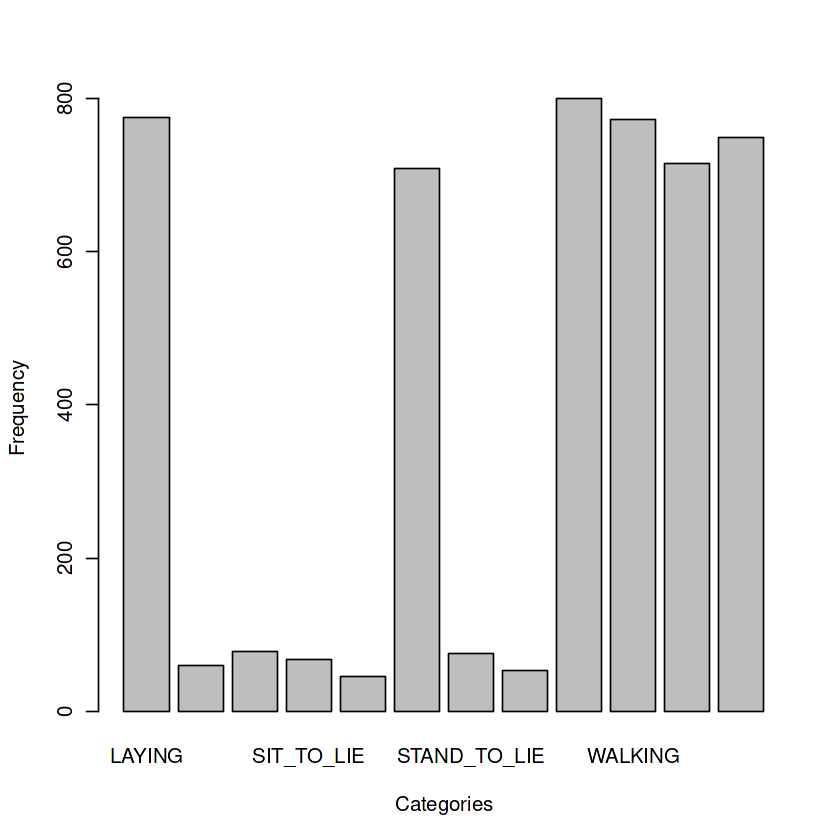

In [49]:
cat_counts = table(train_df_add$activity)

# frequency table
print(cat_counts)

# plot distributions
barplot(cat_counts, xlab="Categories", ylab="Frequency")

One of the penalties associated with QDA’s added flexibility is that if any groups have fewer observations, *n*, than discriminating variables, *p*, the covariance matrix for that group is singular and QDA cannot be performed (STATA manual, discrim qda).

The discriminating variables are essentially the predictors; in our case, we have 73 predictors. In our training dataset, we have some classes (like *lie-to-sit* (60), *sit-to-lie* (68), *sit-to-stand* (45) and *stand-to-sit* (53)) that have fewer observations than the number of predictors (73) which is why the QDA cannot be performed.

<a id="subsection-four-models"></a>
### 8.4 K Nearest Neighbors

K Nearest Neighbors (K-NN) is a non-parametric approach for classification problems. In order to make a prediction for an observation X = x, the training observations that are closest to x are identified. Then X is assigned to the class to which the majority of these observations belong (James et al., 2021). Therefore, KNN is a simple and effective algorithm for activity recognition, particularly when the dataset is not very large. We applied the K-NN algorithm to the full dataset. The K-NN algorithm was applied with the resampling method 10-fold cross-validation.

#### Scaling
  
K-NN relies on distance metrics, such as Euclidean distance, to measure the similarity between data points based on which it predicts class correspondence. These distance calculations are sensitive to the scale of the variables. Therefore, it is important that the variables are standardized. If variables are not standardized some variables play a bigger role than others, leading to biased results. We therefore pre-processed the features by standardizing them applying Z-score scaling (scaling to have a mean of 0 and a standard deviation of 1) (Sejnowski & Gorman). The K-NN algorithm was applied with the resampling method 10-fold cross-validation

##### Result

Accuracy was used to select the optimal model using the largest value. The final value used for the model was .......

#### 8.4.1 With our original features (Model 4a)

In [76]:
set.seed(3)

fit_knn = caret::train(activity ~., 
                       data = train_df_base, 
                       method = "knn",
                       trControl = trcntr,
                       preProcess = "scale")
                       
fit_knn

k-Nearest Neighbors 

4900 samples
  71 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

Pre-processing: scaled (71) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4411, 4412, 4410, 4409, 4410, 4409, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.8655181  0.8424847
  7  0.8728584  0.8510572
  9  0.8700029  0.8476545

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 7.

#### 8.4.2 With our original features + additional features (Model 4b)

In [77]:
set.seed(3)

fit_knn_add = caret::train(activity ~., 
                       data = train_df_add, 
                       method = "knn",
                       trControl = trcntr,
                       preProcess = "scale")
                       
fit_knn_add

k-Nearest Neighbors 

4900 samples
 104 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

Pre-processing: scaled (104) 
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4411, 4412, 4410, 4409, 4410, 4409, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.8910200  0.8724108
  7  0.8914257  0.8728639
  9  0.8873520  0.8680544

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 7.

<a id="subsection-five-models"></a>
### 8.5 Naive Bayes

The Naive Bayes algorithm is a classifier with a single "naive" assumption. The classifier is based on Bayes' theorem, which relates the conditional probability of an event (in this case, a class label) given some observed evidence (features) to the prior probability of that event.

Bayes' Theorem: 
Bayes' theorem for classification can be expressed as:
    P(Class | Features) = (P(Features | Class) * P(Class)) / P(Features)
    P(Class | Features): The probability of the class given the observed features (what we want to predict).
    P(Features | Class): The probability of observing the features given the class (likelihood).
    P(Class): The prior probability of the class (before considering the features).
    P(Features): The probability of observing the features (a normalization constant).

The "naive" part of Naive Bayes comes from the assumption that the features used for classification are conditionally independent, given the class label. This is often an oversimplification but makes the algorithm computationally efficient and often leads to effective classification results in practice.

The Naive Bayes classifier is a simple probabilistic model that can work well for activity recognition, especially when we have limited training data. Thus, it was applied in order to fit a model to predict activity based on all parameters.

#### 8.5.1 With our original features (Model 5a)

In [78]:
set.seed(3)

fit_nb <- caret::train(activity ~ ., 
                       data = train_df_base, 
                       method = "naive_bayes", 
                       trControl = trcntr)
fit_nb

Naive Bayes 

4900 samples
  71 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4411, 4412, 4410, 4409, 4410, 4409, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE      0.7095854  0.6641425
   TRUE      0.7607926  0.7229395

Tuning parameter 'laplace' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were laplace = 0, usekernel = TRUE
 and adjust = 1.

#### 8.5.2 With our original features + additional features (Model 5b)

In [79]:
set.seed(3)

fit_nb_add <- caret::train(activity ~ ., 
                       data = train_df_add, 
                       method = "naive_bayes", 
                       trControl = trcntr)
fit_nb_add

Naive Bayes 

4900 samples
 104 predictor
  12 classes: 'LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SIT_TO_LIE', 'SIT_TO_STAND', 'SITTING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4411, 4412, 4410, 4409, 4410, 4409, ... 
Resampling results across tuning parameters:

  usekernel  Accuracy   Kappa    
  FALSE      0.7373461  0.6957396
   TRUE      0.7848864  0.7508228

Tuning parameter 'laplace' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were laplace = 0, usekernel = TRUE
 and adjust = 1.

<a id="section-nine"></a>
## 9 Test data

### 9.1 Extract features on all elements of test data
We apply the `extract_features()` function on all elements in accelerometer test files and gyroscope test files. The following code merges the data of files into one dataframe using `map_dfr()` for both accelerometer test files and gyroscope test files. 

In [80]:
### ACCELEROMETER TEST DATA ------------------------------------------

# obtain a list of all files
acc_filenames <- dir("./RawData/Test/", "^acc", full.names = TRUE)

# run extract_features() on all elements in obtained files and bind results of the accelerometer data files row wise
acc_test_data = map_dfr(acc_filenames, extract_features, sample_labels) 


### GYROSCOPE TEST DATA ----------------------------------------------

# obtain a list of all files
gyro_filenames <- dir("./RawData/Test/", "^gyro", full.names = TRUE)

# run extract_features() on all elements in obtained files and bind results of the gyroscope data files row wise
gyro_test_data = map_dfr(gyro_filenames, extract_features, sample_labels) 

Warning message:
“There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `AR2_2 = lagged_cor(X2, lag = 2)`.
ℹ In group 139: `epoch = 138`.
Caused by warning in `cor()`:
! the standard deviation is zero
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


### 9.2 Merging test data

In order to process all data, the resulting dataframes of features from all files were combined in one dataframe along with five other variables. This dataframe contains accelerometer test data files (the ones starting with `acc`) as well as gyroscope test data (filenames starting with `gyro`).

In [81]:
test_data <- acc_test_data %>%
  left_join(gyro_test_data, 
            by = c("epoch", "user_id", "exp_id", "activity", "sampleid", "n_samples"),
            suffix = c("_acc", "_gyro")) # to distinguish between same columns of two diff datasets

# checking test dataset
test_data %>%
    head(3)
dim(test_data)

test_data_edited <- test_data %>%
    mutate(across(everything(), ~replace_na(.x,1)))
    
dim(test_data_edited)

epoch,user_id,exp_id,activity,sampleid,mean1_acc,mean2_acc,mean3_acc,median_1_acc,median_2_acc,⋯,iqr2_gyro,iqr3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,ara_gyro,sma_gyro
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2,3,-,0,0.1693034,-0.2382921,0.8003690,0.3736111,-0.09861112,⋯,1.5623642,1.11879973,1,1,1,0.1496063,0.1417323,0.09448819,2.0612300,0.0170844930
1,2,3,-,128,0.8997071,-0.3948568,-0.2429905,0.9541667,-0.32222224,⋯,0.6942484,0.82894414,1,1,1,0.1811024,0.2519685,0.12598425,1.1489864,0.0051854585
2,2,3,-,256,0.9974935,-0.2712565,0.1135525,0.9972222,-0.26944447,⋯,0.1346958,0.06001751,51,38,2,0.2913386,0.2047244,0.28346457,0.1857889,0.0009703451


[1] 2550  176

<a id="section-ten"></a>
## 10 Model comparison

Based on the barplot it can be shown that the K-NN classifier with our original features AND the additional features performed the best in predicting the correct activity based on the accelerometer and gyroscope data.

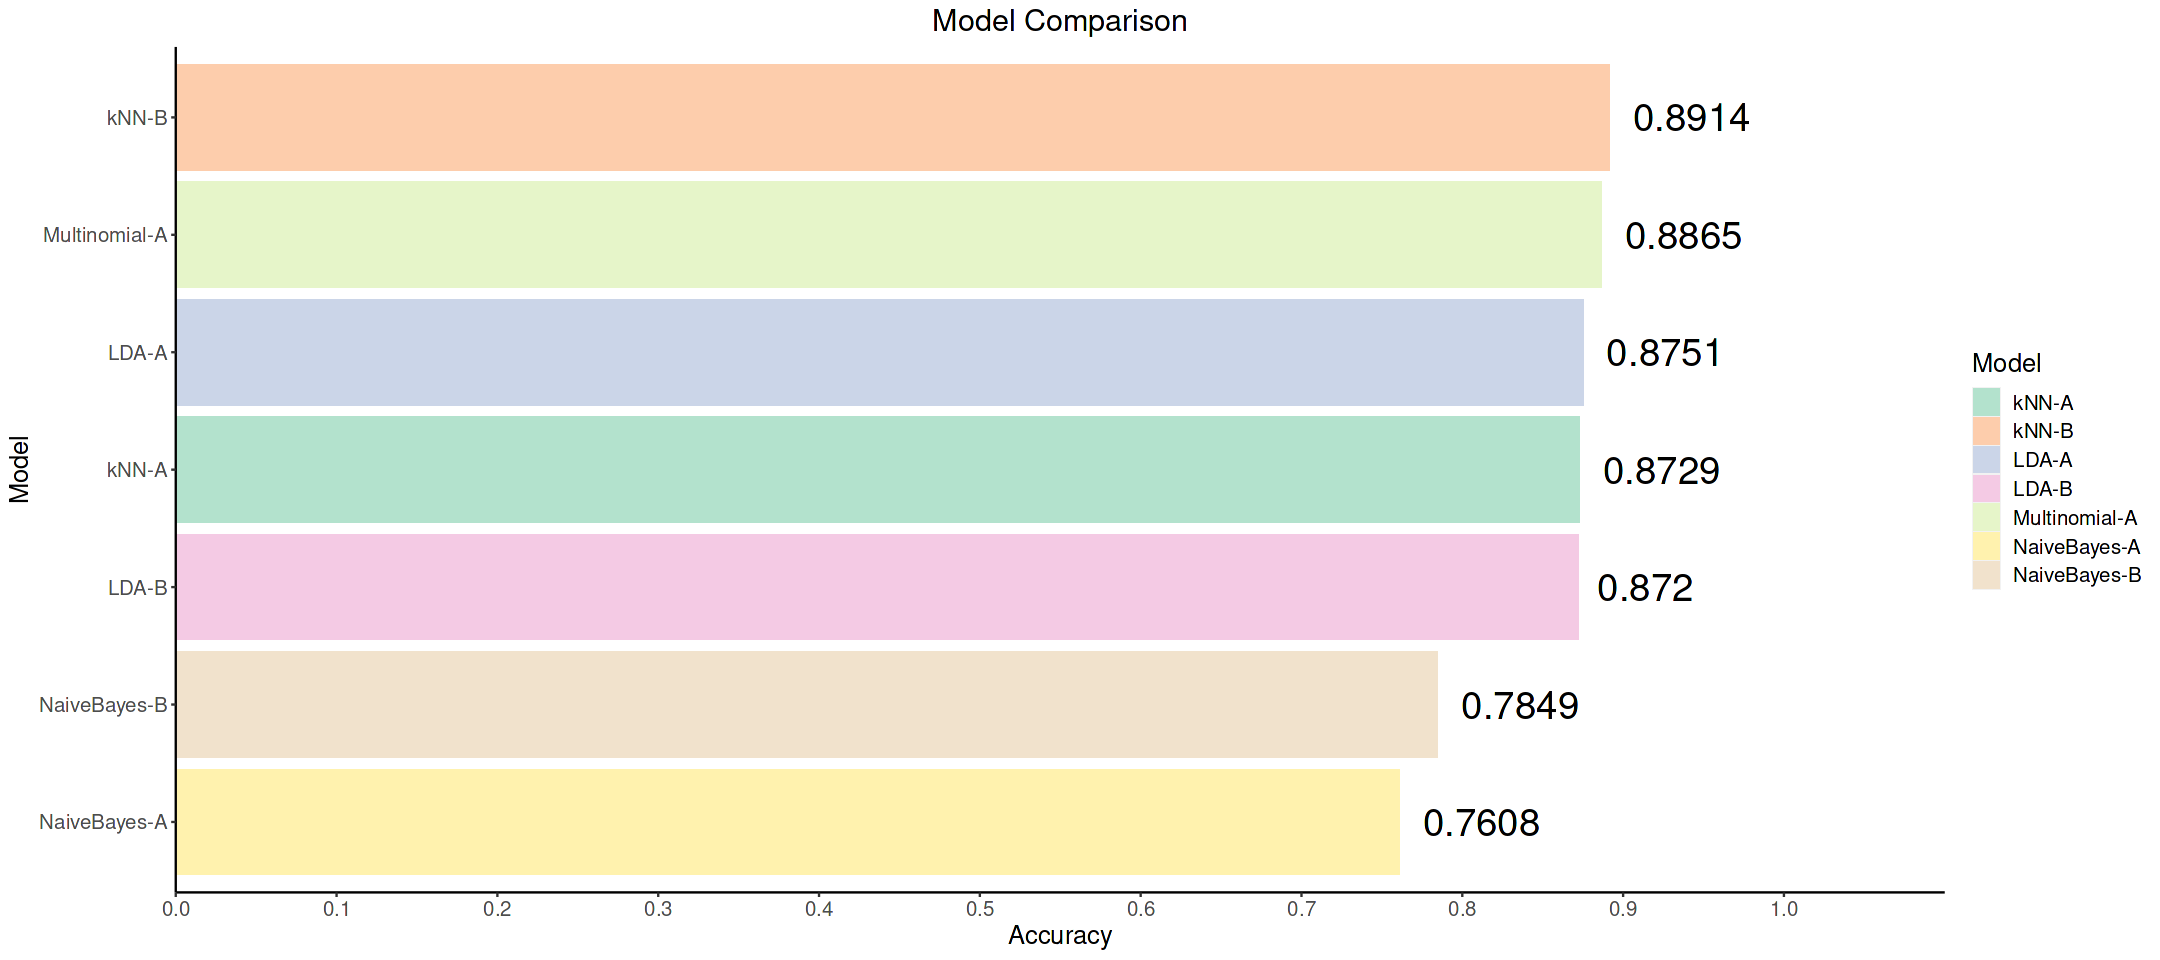

In [82]:
options(repr.plot.width=18, repr.plot.height=8)

models = list(Multinomial_a = fit_multinomial,
              LDA_a = fit_lda, 
              LDA_b = fit_lda_add,
              kNN_a = fit_knn,
              kNN_b = fit_knn_add, 
              NB_a = fit_nb,
              NB_b = fit_nb_add)

plot_df <- tibble(Model = c("LDA-A", "LDA-B", "Multinomial-A", "kNN-A", "kNN-B", "NaiveBayes-A", "NaiveBayes-B"),
                 Acc = c(sapply(models, function(mdl) max(mdl$results$Accuracy))))
                                

plot_df %>% 
  ggplot(aes(x = reorder(Model, Acc),
             y = Acc, 
             fill = Model)) + 
    geom_bar(position = "dodge", stat = "identity") + 
    geom_text(aes(label = round(Acc, 4)), 
              position = position_dodge(width = 0.9), 
              size = 8,  
              hjust = -0.2) +
    scale_y_continuous(limits = c(0, 1), 
                       breaks = seq(0, 1, by = 0.1),
                       expand = expansion(mult = c(0, .1))) +
    coord_flip() +
    scale_fill_brewer(palette = "Pastel2") + # or "Spectral" for something brighter
    labs(title = "Model Comparison",
         x = "Model", 
         y = "Accuracy") +
    theme(panel.background = element_blank(), axis.line = element_line(colour = "black"),
          plot.title = element_text(hjust = 0.5), text = element_text(size = 15))

<a id="section-eleven"></a>
## 11 Discussion

Task of the Physicial Activity competition was to predict the activity of an individual given accelerometer data and gyroscrope dderieved from smartphones. Labeled triaxial movement data was used to train the models on 12 activitiy labels / classes. The data set consisted of 4900 observations after data preprocessing. Datapoints were deleted if the epoch was unlabelled (because predictions are not possible to evaluate), if the data contained NA's or if the variables were redunant, e.g. through near-zero variance, high correlation among two variables, or multicollinearity. The base training set consisted of 71 predictors which included time invariant features like means, standard deviation, medians of the signals, time domain features, like autocorrelations among signals, as well as frequency domain features like peak frequency or mean and standard deviation of the spectrum. Further, an extended training set was created containing 104 predictors which included additional features like the zero-crossing rate or the signal magnitude area (SMA). A total of 71 in the case of the base training model and 104 predictors in the case of the extended training model, respectively, was used to fit different classification models: 

First, we fitted a multinomial regression model using the base training dataset containing of 71 predictors. This lead to a high accuracy of 0.875 with a decay value of 0.1. A trial to fit a multinomial regression model on the full training dataset failed because the model consisted of too many weights.

Second, a linear discriminant analysis (LDA) was executed on the base training dataset (71 predictors) as well as on the full training dataset (104 predictors). As expected, the accuracy of the LDA model with all 104 predictors led to a higher accuracy of 0.887 as compared to the accuracy of the LDA model with 71 predictors (0.872). 

Thirdly, we attempted to fit a quadratric discriminant analysis (QDA). Nevertheless, the QDA model fitting failed because some of the activity classes were too small (James et al., 2013). 

Fourth, we fitted K-NN models with scaled and unscaled features on the base training dataset consisting of 71 predictors and on the training dataset consisting of 104 predictors. Given that feature scaling is necessary in K-NN we only compared K-NN models with scaled features. The K-NN model containing the full set of 104 predictors and k = 7 classes seemed to perform best with an accuracy of 0.891. Even with suboptimal k = 7 or k = 9 the K-NN model on the full training dataset performed better in regards to accuracy (k = 5 with accuracy of 0.891 and k = 9 with accuracy of 0.887) compared to K-NN models fitted to the base training set. Fitting a K-NN model to the base training dataset led to a maximum accuracy of 0.873 using k = 7 classes.

Fifth, we fitted naive Bayes model under the simplified assumption that the features of a class are independent. The naive Bayes algorithm did not perform very well with an accuracy of 0.761 for the base training dataset consisting of 71 predictors and an accuracy of 0.785 for the training dataset consisiting of 104 predictors.

Finally, we tried to fit a Ridge regression model, Lasso Model, Principal Component Regression Model, as well as Partial Least Square model. All of the models were omitted because they are not meaningful in classification problems. 

Based on the accuracy estimate of the models, it seems like the K-NN model with 104 predicotrs and k = 7 classes performed the best with the highest accuracy of 0.891. The second best model in regards to classification accuracy was the classifier model based on LDA containing all 104 predictors with an accuracy of 0.887. This was followed by the multinomial regression model based on 71 predictors with an accuracy of 0.875. In contrast, classification models based on Naive Bayes appeared not to perform too well in regards to classification accuracy.


1. K-NN model all predictors
2. LDA all predictors
3. Multinomial regression 71 predictors
4. K-NN with 71 predictors 
5. LDA with 71 predictors 
6. BM with all predictors
7. BM with 71 predictors

<a id="section-twelve"></a>
## 12 Submissions

We decided to submit the predictions based on the LDA model. The reason for that origins from overfitting: k-NN is a non-parametric algorithm meaning that it doesn't make any assumptions about the underlying data distribution. Instead, k-NN makes predictions based on the majority class among its k nearest neighbors in the feature space. The choice of the parameter k (the number of neighbors to consider) thereby influences the model's performance. When the value of k is small, k-NN is highly sensitive to the noise in the training data, which can result in overfitting. This occurs when it fits the training data very closely, including the noise, leading to poor generalization on the test data.

Therefore we chose to submit the predictions of the LDA model. LDA is a parametric algorithm meaning that it makes the assumptions about the distribution of the data following a multivariate normal distribution. LDA seeks linear combinations of features that maximize class separability while minimizing within-class variance. Because LDA has a fixed number of parameters to estimate based on these assumptions, it tends to have a lower risk of overfitting compared to non-parametric models like k-NN (James et al., 2021).

### 12.1 Using K-NN predictions

The model comparison yielded that the K-NN classifier with k = 7 and 104 scaled features had the best classification accuracy of 0.891. Thus, the fitted K-NN model was used in the competition.

In [87]:
knn_pred <- predict(fit_knn_add, newdata = test_data_edited)
length(knn_pred)

head(knn_pred, 20)

[1] 2550

[1] WALKING_DOWNSTAIRS WALKING_UPSTAIRS   STANDING           STANDING          
 [5] STANDING           STANDING           STANDING           STANDING          
 [9] STANDING           STANDING           STANDING           WALKING_DOWNSTAIRS
[13] STANDING           SITTING            STANDING           STANDING          
[17] SITTING            SITTING            STANDING           STANDING          
12 Levels: LAYING LIE_TO_SIT LIE_TO_STAND SIT_TO_LIE SIT_TO_STAND ... WALKING_UPSTAIRS

In [85]:
testing_knn <- test_data %>%
  mutate(activity = knn_pred)

head(testing_knn)

epoch,user_id,exp_id,activity,sampleid,mean1_acc,mean2_acc,mean3_acc,median_1_acc,median_2_acc,⋯,iqr2_gyro,iqr3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,ara_gyro,sma_gyro
<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2,3,WALKING_DOWNSTAIRS,0,0.1693034,-0.2382921,0.8003690,0.3736111,-0.09861112,⋯,1.56236421,1.11879973,1,1,1,0.14960630,0.1417323,0.09448819,2.06122998,1.708449e-02
1,2,3,WALKING_UPSTAIRS,128,0.8997071,-0.3948568,-0.2429905,0.9541667,-0.32222224,⋯,0.69424835,0.82894414,1,1,1,0.18110236,0.2519685,0.12598425,1.14898644,5.185458e-03
2,2,3,STANDING,256,0.9974935,-0.2712565,0.1135525,0.9972222,-0.26944447,⋯,0.13469578,0.06001751,51,38,2,0.29133858,0.2047244,0.28346457,0.18578888,9.703451e-04
3,2,3,STANDING,384,0.9928928,-0.2702691,0.1391276,0.9930556,-0.26944447,⋯,0.03092505,0.02794708,1,1,95,0.04724409,0.1496063,0.16535433,0.04669404,3.946046e-04
4,2,3,STANDING,512,0.9908854,-0.2861979,0.1286350,0.9909722,-0.28611112,⋯,0.02099849,0.02183843,2,1,1,0.11023622,0.1732283,0.13385827,0.03161536,2.515047e-04
5,2,3,STANDING,640,0.9909180,-0.2904948,0.1215712,0.9902778,-0.28888890,⋯,0.01672244,0.02328924,1,22,64,0.14960630,0.1732283,0.18897638,0.02494609,7.786146e-05


In [86]:
# write CSV files with predictions

testing_knn %>%

    # prepend "user" and "exp" to user_id and exp_id
    mutate(
        user_id = paste(ifelse(user_id < 10, "user0", "user"), user_id, sep=""), 
        exp_id = paste(ifelse(exp_id < 10, "exp0", "exp"), exp_id, sep="")
    ) %>% 

    # unit columnes user_id, exp_id and sample_id into a string 
    # separated by "_" and store it in the new variable `Id`
    unite(Id, user_id, exp_id, sampleid) %>%

    # retain only the `Id` and  predictions
    dplyr::select(Id, Predicted = activity) %>%

    # write to file
    write_csv("test_set_predictions_knn.csv")


# Check the result: print first 20 lines in the submission file
cat(readLines("test_set_predictions_knn.csv",20), sep="\n")

Id,Predicted
user02_exp03_0,WALKING_DOWNSTAIRS
user02_exp03_128,WALKING_UPSTAIRS
user02_exp03_256,STANDING
user02_exp03_384,STANDING
user02_exp03_512,STANDING
user02_exp03_640,STANDING
user02_exp03_768,STANDING
user02_exp03_896,STANDING
user02_exp03_1024,STANDING
user02_exp03_1152,STANDING
user02_exp03_1280,STANDING
user02_exp03_1408,WALKING_DOWNSTAIRS
user02_exp03_1536,STANDING
user02_exp03_1664,SITTING
user02_exp03_1792,STANDING
user02_exp03_1920,STANDING
user02_exp03_2048,SITTING
user02_exp03_2176,SITTING
user02_exp03_2304,STANDING


### 12.2 Using multinomial predictions

The model comparison yielded that the multinomial model containing all 104 predictors had a quite high classification accuracy of 0.875. Thus, we also made predictions on the test dataset based on the multinomial model.

In [90]:
multinom_pred <- predict(fit_multinomial, newdata = test_data_edited)

head(multinom_pred, 20)


testing_multinom <- test_data %>%
  mutate(activity = multinom_pred)

head(testing_multinom)


# write CSV files with predictions

testing_multinom %>%

    # prepend "user" and "exp" to user_id and exp_id
    mutate(
        user_id = paste(ifelse(user_id < 10, "user0", "user"), user_id, sep=""), 
        exp_id = paste(ifelse(exp_id < 10, "exp0", "exp"), exp_id, sep="")
    ) %>% 

    # unit columnes user_id, exp_id and sample_id into a string 
    # separated by "_" and store it in the new variable `Id`
    unite(Id, user_id, exp_id, sampleid) %>%

    # retain only the `Id` and  predictions
    dplyr::select(Id, Predicted = activity) %>%

    # write to file
    write_csv("test_set_predictions_multinom.csv")


# Check the result: print first 20 lines in the submission file
cat(readLines("test_set_predictions_multinom.csv",20), sep="\n")

[1] LIE_TO_STAND STANDING     STANDING     STANDING     STANDING    
 [6] STANDING     STANDING     STANDING     STANDING     STANDING    
[11] STANDING     SIT_TO_STAND STAND_TO_SIT SITTING      SITTING     
[16] SITTING      SITTING      SITTING      SITTING      SITTING     
12 Levels: LAYING LIE_TO_SIT LIE_TO_STAND SIT_TO_LIE SIT_TO_STAND ... WALKING_UPSTAIRS

epoch,user_id,exp_id,activity,sampleid,mean1_acc,mean2_acc,mean3_acc,median_1_acc,median_2_acc,⋯,iqr2_gyro,iqr3_gyro,dist_max1_gyro,dist_max2_gyro,dist_max3_gyro,zcr1_gyro,zcr2_gyro,zcr3_gyro,ara_gyro,sma_gyro
<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2,3,LIE_TO_STAND,0,0.1693034,-0.2382921,0.8003690,0.3736111,-0.09861112,⋯,1.56236421,1.11879973,1,1,1,0.14960630,0.1417323,0.09448819,2.06122998,1.708449e-02
1,2,3,STANDING,128,0.8997071,-0.3948568,-0.2429905,0.9541667,-0.32222224,⋯,0.69424835,0.82894414,1,1,1,0.18110236,0.2519685,0.12598425,1.14898644,5.185458e-03
2,2,3,STANDING,256,0.9974935,-0.2712565,0.1135525,0.9972222,-0.26944447,⋯,0.13469578,0.06001751,51,38,2,0.29133858,0.2047244,0.28346457,0.18578888,9.703451e-04
3,2,3,STANDING,384,0.9928928,-0.2702691,0.1391276,0.9930556,-0.26944447,⋯,0.03092505,0.02794708,1,1,95,0.04724409,0.1496063,0.16535433,0.04669404,3.946046e-04
4,2,3,STANDING,512,0.9908854,-0.2861979,0.1286350,0.9909722,-0.28611112,⋯,0.02099849,0.02183843,2,1,1,0.11023622,0.1732283,0.13385827,0.03161536,2.515047e-04
5,2,3,STANDING,640,0.9909180,-0.2904948,0.1215712,0.9902778,-0.28888890,⋯,0.01672244,0.02328924,1,22,64,0.14960630,0.1732283,0.18897638,0.02494609,7.786146e-05


Id,Predicted
user02_exp03_0,LIE_TO_STAND
user02_exp03_128,STANDING
user02_exp03_256,STANDING
user02_exp03_384,STANDING
user02_exp03_512,STANDING
user02_exp03_640,STANDING
user02_exp03_768,STANDING
user02_exp03_896,STANDING
user02_exp03_1024,STANDING
user02_exp03_1152,STANDING
user02_exp03_1280,STANDING
user02_exp03_1408,SIT_TO_STAND
user02_exp03_1536,STAND_TO_SIT
user02_exp03_1664,SITTING
user02_exp03_1792,SITTING
user02_exp03_1920,SITTING
user02_exp03_2048,SITTING
user02_exp03_2176,SITTING
user02_exp03_2304,SITTING


<a id="section-thirteen"></a>
## 13 References

Applied Time Series Analysis. Chapter 8: Cross Correlation Functions and Lagged Regressions. PennState Eberly College of Science. Retreived from: https://online.stat.psu.edu/stat510/lesson/8/8.2

Brownlee, J. (2018). A Gentle Introduction to k-fold Cross-Validation. Machine Learning Mastery. Retrieved from: https://machinelearningmastery.com/k-fold-cross-validation/

Derrick & Thomas (2004). Chapter 7: Time-Series Analysis: The Cross-Correlation Function.

Grasman, R. (2018). Feature extraction from Signals. DropBox. Retrieved from: https://paper.dropbox.com/doc/Feature-extraction-from-Signals-qCp5uvj47gmyuw5nmB8lL

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (1st ed.). Springer.

Janson, S (2020). Understanding R's Cross Correlation ccf. github. Retreived from: https://github.com/SigurdJanson/ccf21/blob/master/pub/CrossCorrelations.md

R - Mean, Median and Mode (2023). tutorialspoint. Retrieved from: https://www.tutorialspoint.com/r/r_mean_median_mode.htm

Seifert, J. (2020). The R Cross Correlation Function. Retrieved from: https://medium.com/@jan.seifert/the-r-cross-correlation-function-f5f426006425

Sejnowski, T. & Gorman,R. Connectionist Bench (Sonar, Mines vs. Rocks). UCI Machine Learning Repository. https://doi.org/10.24432/C5T01Q.

Smith, T. (2023). Autocorrelation: What It Is, How It Works, Tests. Investopedia. Retreived from: https://www.investopedia.com/terms/a/autocorrelation.asp#:~:text=Autocorrelation%20represents%20the%20degree%20of,value%20and%20its%20past%20values.

Discrim qda. stata.com. Retrieved from: https://www.stata.com/manuals13/mvdiscrimqda.pdf

Williams, J. H., Rizzuto, S. F., Dillard, B. A., & Whitaker, E. J. (2022). Complementary use of wearable technology 3: Temporal alignment and similarity measures of accelerometer signals from two IMU devices.

<a id="section-fourteen"></a>
## 14 Task division

* **Sophia:** Features, Literature search, Notebook explanations and formatting
* **Nitya:** Features, Model fitting & comparison